In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold

import xgboost as xgb
from xgboost import XGBRegressor

from src.config import (
    RANDOM_STATE, 
    TEST_SIZE, 
    TOP_FEATURES, 
    N_SPLITS, 
    DATA_PROCESSED
)
from src.models import (
    Baseline,
    plot_importance,
    select_top_features,
    evaluate_model
)

In [2]:
df = pd.read_csv(f'{DATA_PROCESSED}/train_FD001_features.csv')
df.head()

,unit_number,time_cycles,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,...,sensor_9_mean_5,sensor_11_mean_5,sensor_12_mean_5,sensor_13_mean_5,sensor_14_mean_5,sensor_14_std_5,sensor_15_mean_5,sensor_17_mean_5,sensor_20_mean_5,sensor_21_mean_5
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,...,9046.190000,47.470,521.660,2388.020,8138.620000,0.000000,8.419500,392.000000,39.060000,23.419000
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,...,9045.130000,47.480,521.970,2388.045,8135.055000,5.041671,8.425650,392.000000,39.030000,23.421300
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,...,9047.733333,47.410,522.120,2388.040,8134.446667,3.717450,8.423033,391.333333,39.003333,23.395600
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,...,9048.170000,47.340,522.305,2388.050,8134.292500,3.050906,8.409325,391.500000,38.972500,23.390175
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,...,9049.566000,47.328,522.282,2388.048,8134.194000,2.651326,8.413340,391.800000,38.958000,23.393020


In [3]:
units = df['unit_number'].unique()

train_units, test_units = train_test_split(units, test_size=TEST_SIZE, random_state=RANDOM_STATE) #split by unit !

train_df = df[df['unit_number'].isin(train_units)]
test_df  = df[df['unit_number'].isin(test_units)]

In [4]:
scaler = StandardScaler()

X_train = train_df.drop(columns=['unit_number','time_cycles','RUL'])
X_train_scaled = scaler.fit_transform(X_train)
y_train = train_df['RUL']

X_test = test_df.drop(columns=['unit_number','time_cycles','RUL'])
X_test_scaled  = scaler.transform(X_test)
y_test = test_df['RUL']

print(X_train.shape, X_test.shape)

(16561, 29) (4070, 29)


Baseline metrics
RMSE_train: 39.84204596539162 RMSE_test: 39.919400484650964
MAE_train : 35.25410871849815 MAE_test : 35.25728054440089
R2_train  : 0.0 R2_test  : -0.00022999362190279093


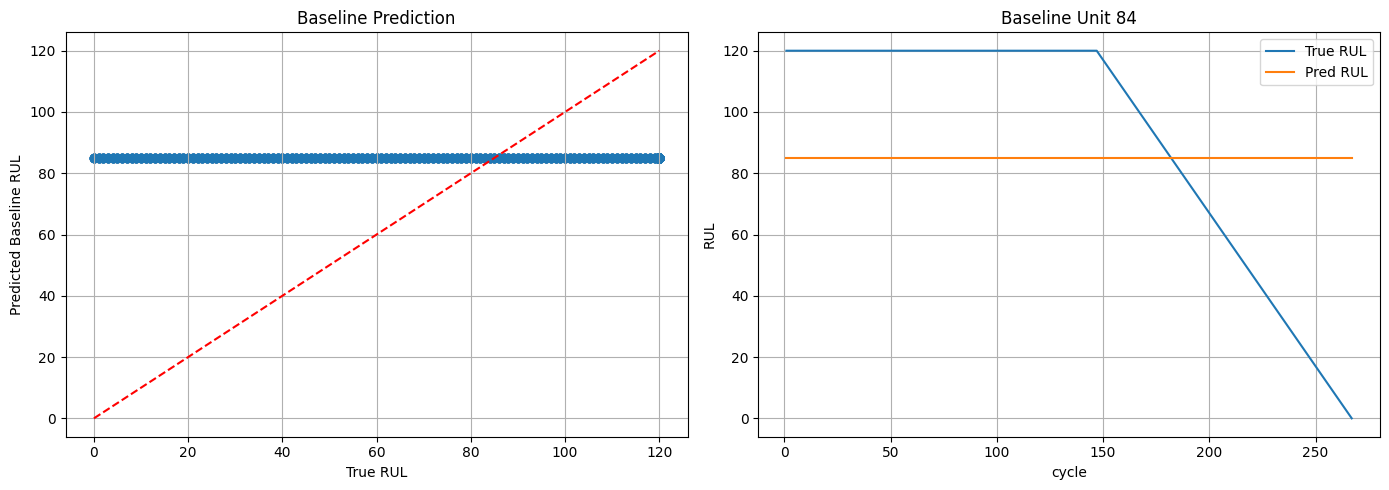

In [5]:
# Baseline

baseline = Baseline().fit(X_train, y_train)
evaluate_model(baseline, X_train, X_test, y_train, y_test,
               test_df, test_units[0], X_train.columns, None, "Baseline")

Linear Regression metrics
RMSE_train: 20.144801605625606 RMSE_test: 19.00343158229487
MAE_train : 16.558041516816417 MAE_test : 15.392676346344517
R2_train  : 0.7443518084342629 R2_test  : 0.7733290232842651


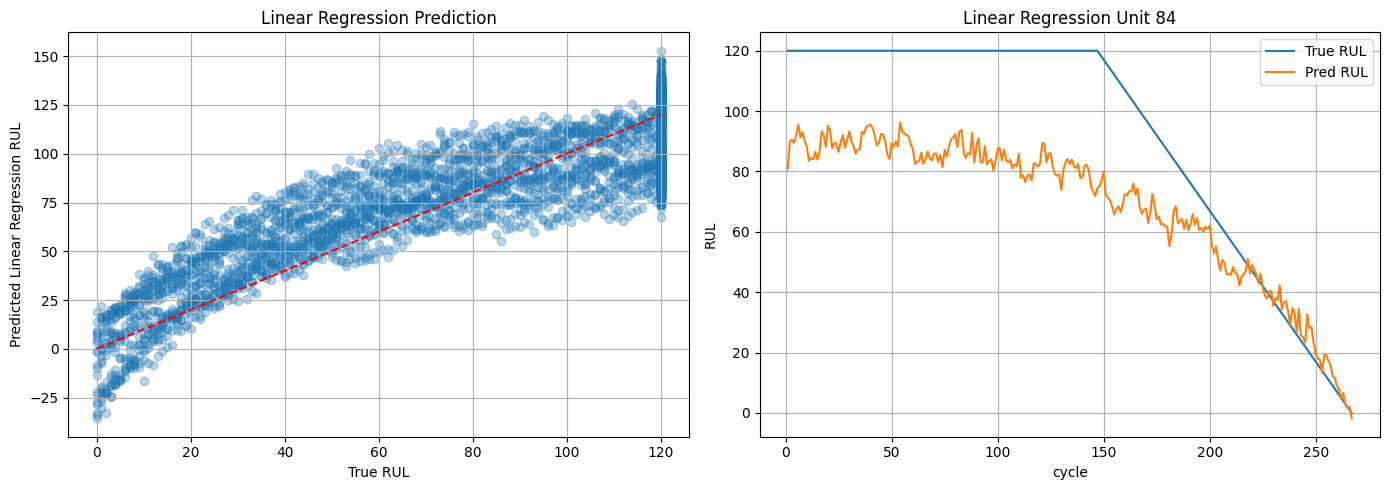

In [6]:
# Linear regression

lr = LinearRegression().fit(X_train_scaled, y_train)
evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test,
               test_df, test_units[0], X_train.columns, scaler, "Linear Regression")

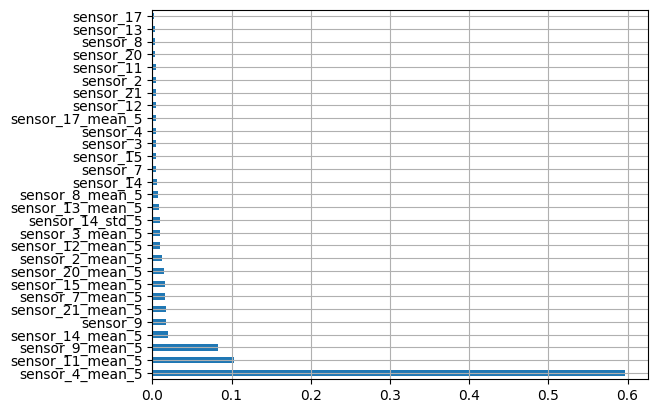

In [7]:
# Random Forest

rf = RandomForestRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
plot_importance(rf, X_train)

Random Forest metrics
RMSE_train: 5.23104665986259 RMSE_test: 15.902022016129717
MAE_train : 3.5526894511201017 MAE_test : 10.915820638820641
R2_train  : 0.9827617202887478 R2_test  : 0.8412782096705219


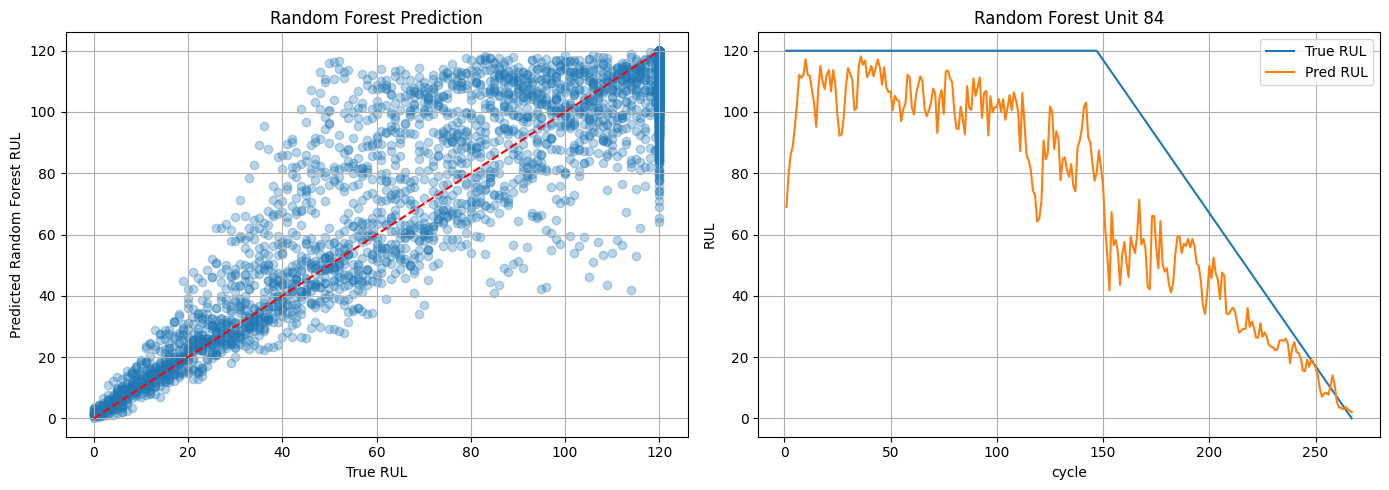

In [8]:
cols = select_top_features(rf, X_train, TOP_FEATURES)
X_train_imp_rf = X_train[cols]
X_test_imp_rf = X_test[cols]

rf_vanilla = RandomForestRegressor(random_state=RANDOM_STATE).fit(X_train_imp_rf, y_train)
evaluate_model(rf_vanilla, X_train_imp_rf, X_test_imp_rf, y_train, y_test,
               test_df, test_units[0], X_train_imp_rf.columns, None, "Random Forest")

In [9]:
# Random Forest Tuned

param_grid = {"n_estimators": [100, 200, 300], 
              "max_depth": [None, 10, 20], 
              "min_samples_leaf": [1, 3, 5]}

grid = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE),
                    param_grid,
                    cv=GroupKFold(n_splits=N_SPLITS),
                    scoring="neg_root_mean_squared_error",
                    n_jobs=-1)

grid.fit(X_train_imp_rf, y_train, groups=train_df.loc[X_train_imp_rf.index, 'unit_number'])

print(grid.best_params_)
print(-grid.best_score_)

{'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 300}
17.26271540894658


RF Tuned metrics
RMSE_train: 13.290758818373456 RMSE_test: 15.509101360413057
MAE_train : 9.154018201093395 MAE_test : 10.708866845350844
R2_train  : 0.888720211927899 R2_test  : 0.8490249710990161


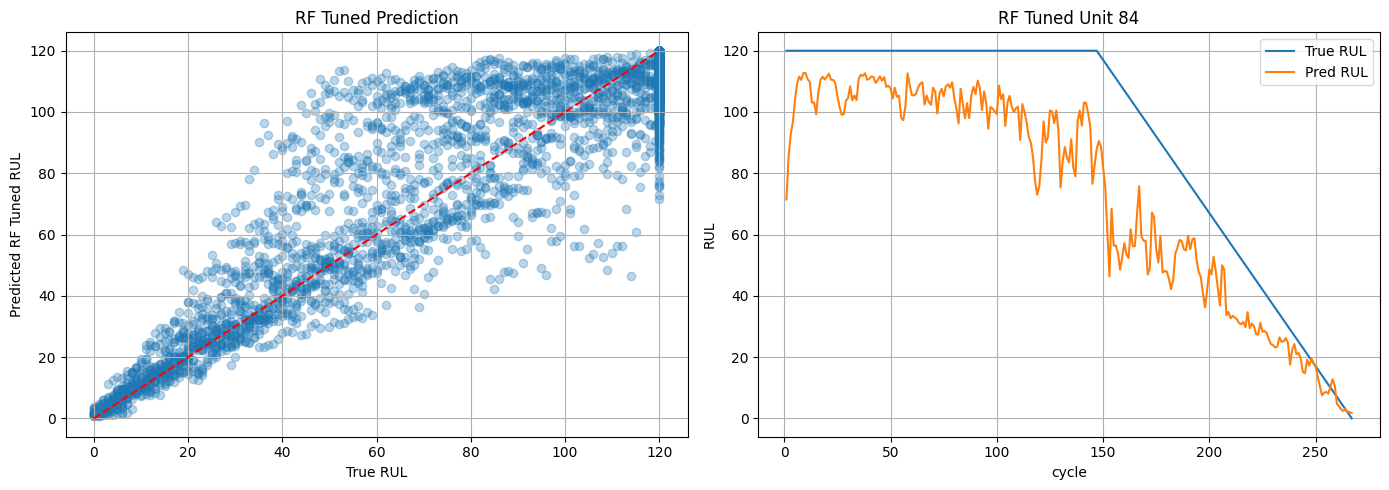

In [10]:
best_rf = grid.best_estimator_
evaluate_model(best_rf, X_train_imp_rf, X_test_imp_rf, y_train, y_test,
               test_df, test_units[0], X_train_imp_rf.columns, None, "RF Tuned")

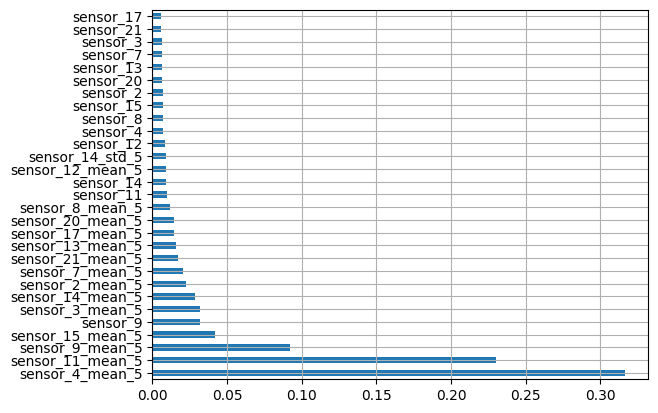

In [11]:
# XGBoost

xgb_ = XGBRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
plot_importance(xgb_, X_train)

XGBoost metrics
RMSE_train: 8.840569561177357 RMSE_test: 16.76199048296985
MAE_train : 6.071855545043945 MAE_test : 11.46268081665039
R2_train  : 0.9507646560668945 R2_test  : 0.8236469030380249


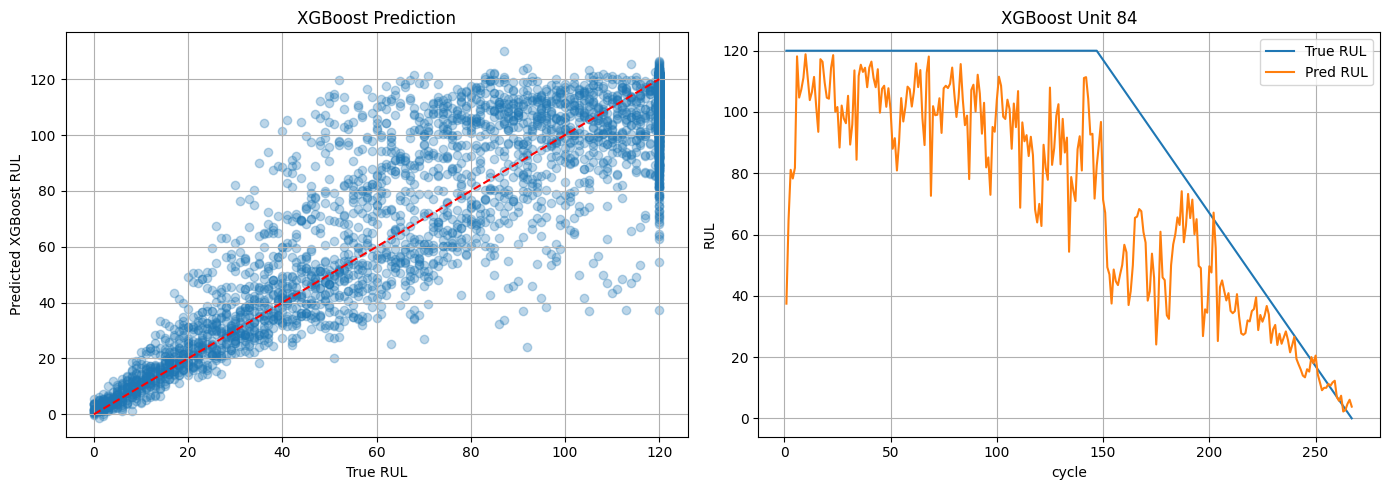

In [12]:
cols = select_top_features(xgb_, X_train, TOP_FEATURES)
X_train_imp_xgb = X_train[cols]
X_test_imp_xgb = X_test[cols]

xgb_vanilla = XGBRegressor(random_state=RANDOM_STATE).fit(X_train_imp_xgb, y_train)
evaluate_model(xgb_vanilla, X_train_imp_xgb, X_test_imp_xgb, y_train, y_test,
               test_df, test_units[0], X_train_imp_xgb.columns, None, "XGBoost")

In [13]:
# XGBoost Tuned

param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2],
}


grid_xgb = GridSearchCV(
    XGBRegressor(random_state=RANDOM_STATE),
    param_grid_xgb,
    cv=GroupKFold(n_splits=N_SPLITS),
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_xgb.fit(X_train_imp_xgb, y_train, groups=train_df.loc[X_train_imp_xgb.index, 'unit_number'])

print("Best params:", grid_xgb.best_params_)
print("Best RMSE (CV):", -grid_xgb.best_score_)

Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best RMSE (CV): 17.13932704925537


XGBoost Tuned metrics
RMSE_train: 16.219142313716166 RMSE_test: 15.582125258239858
MAE_train : 11.726157188415527 MAE_test : 11.218445777893066
R2_train  : 0.8342809677124023 R2_test  : 0.8475999236106873


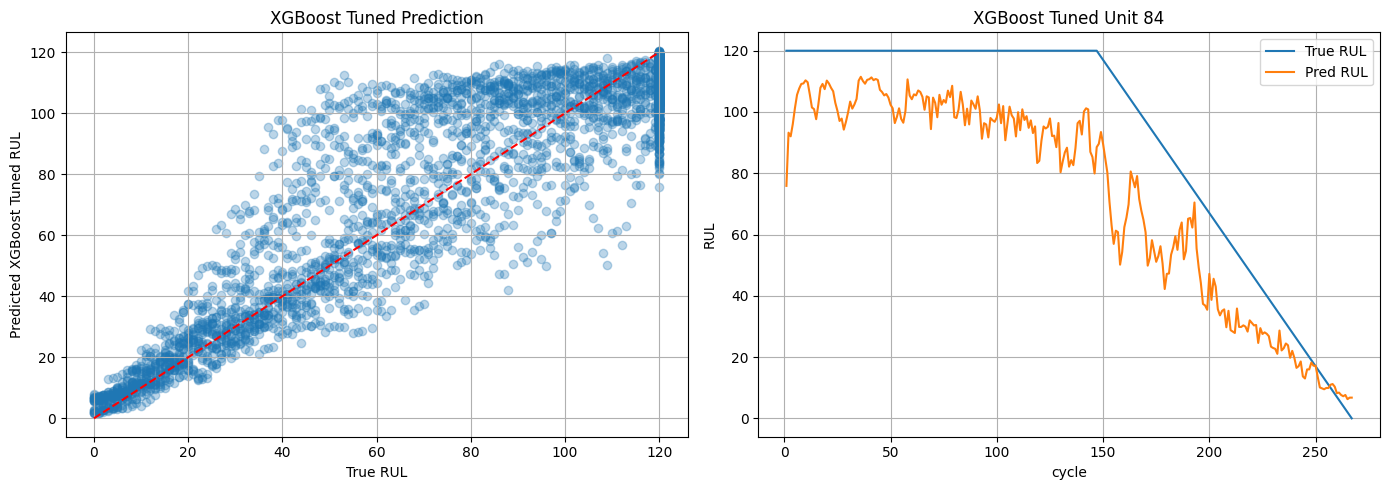

In [14]:
best_xgb = grid_xgb.best_estimator_
evaluate_model(best_xgb, X_train_imp_xgb, X_test_imp_xgb, y_train, y_test,
               test_df, test_units[0], X_train_imp_xgb.columns, None, "XGBoost Tuned")

In [15]:
# LSTM

